<a href="https://colab.research.google.com/github/scott-huberty/DeepUnderstandingOfDeepLearning/blob/codechallenges/FFN/DUDL_FFN_FFNonMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [86]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [87]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

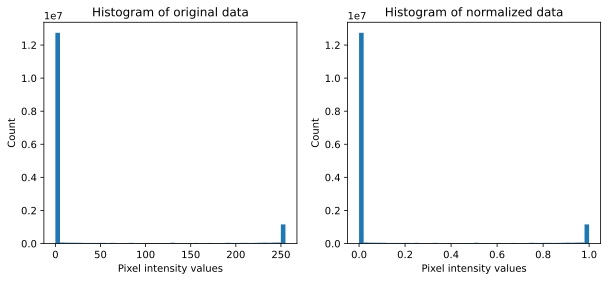

In [88]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [89]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [90]:
# check all variables in workspace
%whos

Variable                   Type             Data/Info
-----------------------------------------------------
DataLoader                 type             <class 'torch.utils.data.dataloader.DataLoader'>
F                          module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset              type             <class 'torch.utils.data.dataset.TensorDataset'>
X                          Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
almost_error_img           Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
almost_errors              ndarray          13: 13 elems, type `int64`, 104 bytes
almost_errors_images       Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
amost_error_img            Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                         ndarray          2: 2 elems, type `object`, 16 bytes
axs                        ndarray          

# Create the DL model

In [91]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [92]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3352, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [93]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    net.train() # set the model to training mode
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      yHat = net(X)

      # compare the following really long line of code to the training accuracy lines
      testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [94]:
trainAcc,testAcc,losses,net = function2trainTheModel()


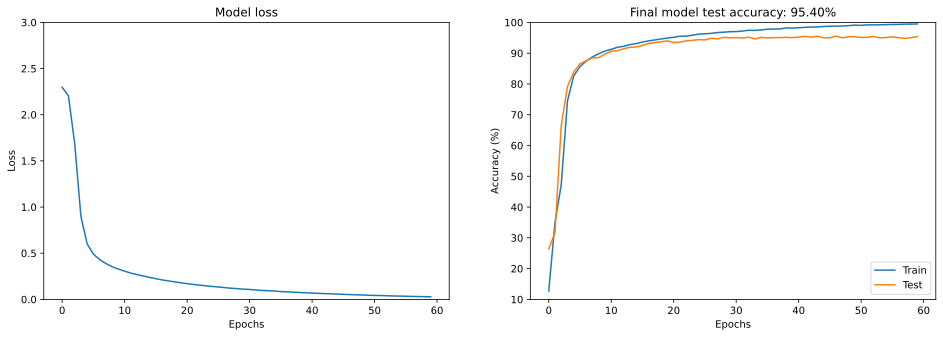

In [95]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [96]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.1390e+01, -2.9331e+01, -2.8330e+01,  ..., -1.4448e+01,
         -1.2212e+01, -7.9870e-06],
        [-1.7002e+01, -4.4741e-04, -1.1870e+01,  ..., -1.2398e+01,
         -7.8010e+00, -1.4428e+01],
        [-9.0348e+00, -9.9077e+00, -1.0765e+01,  ..., -2.2088e+01,
         -1.1872e+01, -1.6942e+01],
        ...,
        [-1.2325e+01, -1.6175e+01, -1.6294e+01,  ..., -9.3613e+00,
         -1.6215e+01, -7.4956e+00],
        [-7.6202e+00, -1.1333e+01, -9.6697e+00,  ..., -1.6528e+01,
         -9.0117e+00, -1.4056e+01],
        [-6.6253e+00, -4.5116e+00, -8.4105e+00,  ..., -1.1366e+01,
         -5.5195e-02, -8.9621e+00]])

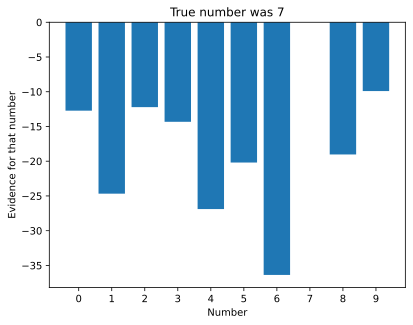

In [97]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [98]:
torch.max(predictions,axis=1)[1]

tensor([9, 1, 6,  ..., 4, 6, 8])

92


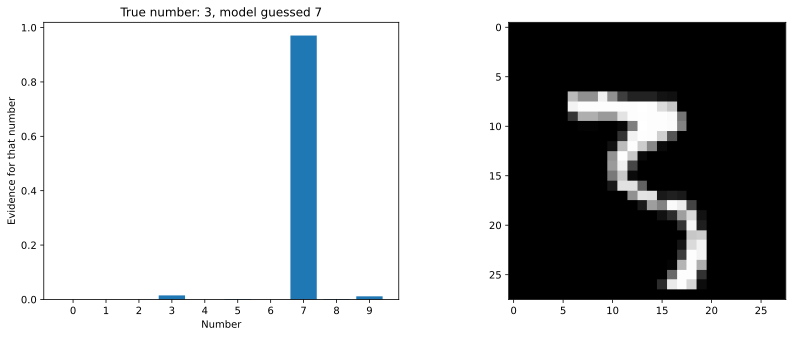

In [99]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(len(errors))

# Evidence for all numbers from one sample
sample2show = 20

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [100]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
#
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
#
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
#
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
#

 ## 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
##    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?

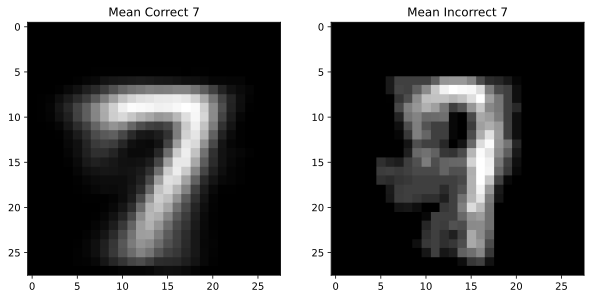

In [101]:
# prompt:  1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#     of all correct 7's and one image of all incorrectly labeled 7's). How do they look?

import matplotlib.pyplot as plt
import numpy as np

# Get the indices of the correct and incorrect 7s
correct_7s = np.where((y == 7) & (torch.argmax(predictions, axis=1) == 7))[0]
incorrect_7s = np.where((y == 7) & (torch.argmax(predictions, axis=1) != 7))[0]

# Extract the images for the correct and incorrect 7s
correct_7s_images = X[correct_7s]
incorrect_7s_images = X[incorrect_7s]

# Calculate the mean image for the correct and incorrect 7s
mean_correct_7 = np.mean(correct_7s_images.numpy(), axis=0)
mean_incorrect_7 = np.mean(incorrect_7s_images.numpy(), axis=0)

# Reshape the mean images to 28x28 and display them
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(mean_correct_7, (28, 28)), cmap='gray')
plt.title('Mean Correct 7')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(mean_incorrect_7, (28, 28)), cmap='gray')
plt.title('Mean Incorrect 7')

plt.show()


2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top and errors on the bottom.

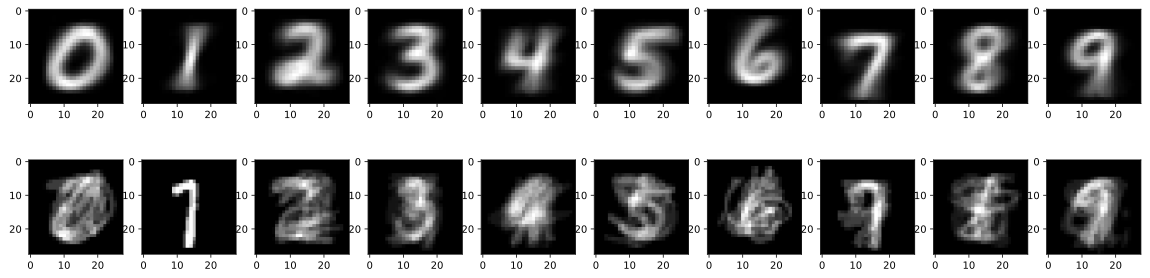

In [102]:
# prompt:  Repeat the cell above for all numbers to produce a 2x10 matrix of images with corrects on top and errors on the bottom.

import matplotlib.pyplot as plt
import numpy as np
# Get the indices of the correct and incorrect numbers
correct_numbers = {}
incorrect_numbers = {}
for i in range(10):
  correct_numbers[i] = np.where((y == i) & (torch.argmax(predictions, axis=1) == i))[0]
  incorrect_numbers[i] = np.where((y == i) & (torch.argmax(predictions, axis=1) != i))[0]

# Extract the images for the correct and incorrect numbers
correct_numbers_images = {}
incorrect_numbers_images = {}
for i in range(10):
  correct_numbers_images[i] = X[correct_numbers[i]]
  incorrect_numbers_images[i] = X[incorrect_numbers[i]]

# Calculate the mean image for the correct and incorrect numbers
mean_correct_numbers = {}
mean_incorrect_numbers = {}
for i in range(10):
  mean_correct_numbers[i] = np.mean(correct_numbers_images[i].numpy(), axis=0)
  mean_incorrect_numbers[i] = np.mean(incorrect_numbers_images[i].numpy(), axis=0)

# Reshape the mean images to 28x28 and display them
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
  axs[0, i].imshow(np.reshape(mean_correct_numbers[i], (28, 28)), cmap='gray')
  axs[1, i].imshow(np.reshape(mean_incorrect_numbers[i], (28, 28)), cmap='gray')

plt.show()


Identify "almost errors," which we can define as correct categorizations that had a probability of e.g., >.1 for any other number

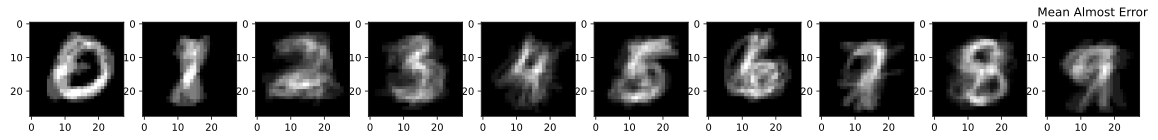

In [104]:
# prompt: Identify "almost errors," which we can define as correct categorizations that had a probability of e.g., >.1 for any other number

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for i in range(10):
  almost_errors = np.where((torch.max(predictions, axis=1)[1] == y) & (y == i) & (torch.max(np.exp(predictions), axis=1)[0] < 0.9))[0]
  almost_error_img = X[almost_errors]
  mean_almost_errors = np.mean(almost_error_img.numpy(), axis=0)
  axs[i].imshow(np.reshape(mean_almost_errors, (28, 28)), cmap='gray')

# Reshape the mean image to 28x28 and display it
plt.title('Mean Almost Error')
plt.show()
